In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Blues')

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black")

    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    fig.tight_layout()
    plt.show()

## Preprocessing (Mandatory for the rest of the notebook to work)

In [2]:
# Random seed
rs = 42

df = pd. read_csv('depression_data.csv')
# Drop name column
df.drop(columns='Name', inplace=True)

# Identify categorical columns (object dtype)
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Remove redundant columns
no_columns = [col for col in df_encoded.columns.tolist() if col.endswith('_No')]
df_reduced = df_encoded.drop(columns=no_columns)

# Normalize the Age and Number of Children columns
df_reduced['Age'] = df_reduced['Age'] / 100
df_reduced['Number of Children'] = df_reduced['Number of Children'] / 4

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data's Income column
scaler.fit(df_reduced[['Income']])

# Transform the Income column in both training and test sets
df_reduced['Income'] = scaler.transform(df_reduced[['Income']])
df_reduced['Income'] = scaler.transform(df_reduced[['Income']])

df_reduced.head()


,Age,Number of Children,Income,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Widowed,Education Level_Associate Degree,Education Level_Bachelor's Degree,Education Level_High School,...,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Fair,Sleep Patterns_Good,Sleep Patterns_Poor,History of Mental Illness_Yes,History of Substance Abuse_Yes,Family History of Depression_Yes,Chronic Medical Conditions_Yes
0,0.31,0.50,-1.247101,0,1,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,1
1,0.55,0.25,-1.247091,0,1,0,0,0,0,1,...,0,0,1,1,0,0,1,0,0,1
2,0.78,0.25,-1.247041,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0.58,0.75,-1.247111,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0.18,0.00,-1.247112,0,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,1,1


In [3]:
# Define X and y
X = df_reduced.drop(columns=['History of Mental Illness_Yes'])
y = df_reduced['History of Mental Illness_Yes']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 331014 samples
Test set size: 82754 samples


## Cross Validation Strategy

In [4]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

## Logistic Regression

In [17]:
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000]
}

random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(class_weight='balanced', random_state=rs),
    param_distributions=param_grid_lr,
    n_iter=5,  
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=rs
)
random_search_lr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:")
print(random_search_lr.best_params_)
print(f"Best ROC AUC: {random_search_lr.best_score_:.4f}")

/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_s

Best parameters for Logistic Regression:
{'solver': 'saga', 'penalty': None, 'max_iter': 1000, 'C': 0.1}
Best ROC AUC: 0.5969


/home/alejandro/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Decision Tree

In [18]:
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=rs),
    param_distributions=param_grid_dt,
    n_iter=5,  
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=rs
)

random_search_dt.fit(X_train, y_train)

print("Best parameters for Decision Tree:")
print(random_search_dt.best_params_)
print(f"Best ROC AUC: {random_search_dt.best_score_:.4f}")


Best parameters for Decision Tree:
{'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'log_loss'}
Best ROC AUC: 0.5953


## Random Forest

In [19]:
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=rs),
    param_distributions=param_grid_rf,
    n_iter=5,  
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=rs
)

random_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:")
print(random_search_rf.best_params_)
print(f"Best ROC AUC: {random_search_rf.best_score_:.4f}")

/home/alejandro/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'log_loss'}
Best ROC AUC: 0.6005


## Support Vector Machine

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 4, 5]  
}

random_search_svm = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=rs, class_weight='balanced'),
    param_distributions=param_grid_svm,
    n_iter=5,  
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=rs
)

random_search_svm.fit(X_train, y_train)

print("Best parameters for SVM:")
print(random_search_svm.best_params_)
print(f"Best ROC AUC: {random_search_svm.best_score_:.4f}")


## XGBoost

In [20]:
# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 1, 5],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2]
}

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(
    scale_pos_weight = 7/3, #based on the class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=rs
)


# Randomized search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=5,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=0,
    random_state=rs
)

# Fit the model
random_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(random_search_xgb.best_params_)
print(f"Best CV ROC AUC: {random_search_xgb.best_score_:.4f}")

/home/alejandro/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators", "classifier__reg_alpha", "classifier__reg_lambda", "classifier__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/alejandro/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:56:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "classifier__colsample_bytree", "classifier__gamma", "classifier__learning_rate", "classifier__max_depth", "classifier__n_estimators", "classifier__reg_alpha", "classifier__reg_lambda", "classifier__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/alejandro/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:56:12] WARNING: /workspace/src/learner.c

Best parameters found:
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 1.5, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__gamma': 1, 'classifier__colsample_bytree': 0.6}
Best CV ROC AUC: 0.5930


## Best models Results 

### Logistic regression

Logistic Regression Test Results:
Accuracy: 0.6153
ROC AUC: 0.5925
Classification Report:
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     57589
           1       0.39      0.46      0.42     25165

    accuracy                           0.62     82754
   macro avg       0.56      0.57      0.57     82754
weighted avg       0.63      0.62      0.62     82754

------------------------------------------------------


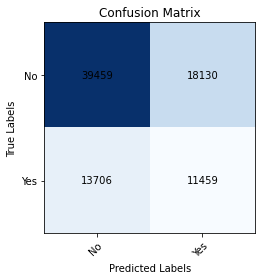

In [26]:
best_lr = random_search_lr.best_estimator_

# Predict on the test set
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Test Results:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC AUC: {roc_auc_lr:.4f}")
print("Classification Report:")
print('------------------------------------------------------')
print(classification_report(y_test, y_pred_lr))
print('------------------------------------------------------')
cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, ['No', 'Yes'])


### Decision Tree

Decision Tree Test Results:
Accuracy: 0.5725
ROC AUC: 0.5929
Classification Report:
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.58      0.65     57589
           1       0.37      0.55      0.44     25165

    accuracy                           0.57     82754
   macro avg       0.56      0.57      0.55     82754
weighted avg       0.63      0.57      0.59     82754

------------------------------------------------------


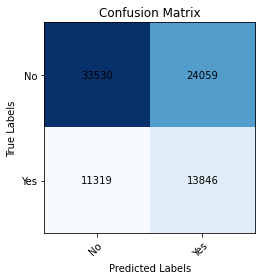

In [23]:
best_dt = random_search_dt.best_estimator_

# Predict on the test set
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)

print("Decision Tree Test Results:")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"ROC AUC: {roc_auc_dt:.4f}")
print("Classification Report:")
print('------------------------------------------------------')
print(classification_report(y_test, y_pred_dt))
print('------------------------------------------------------')
cm = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm, ['No', 'Yes'])



### Random Forest

Random Forest Test Results:
Accuracy: 0.6154
ROC AUC: 0.5973
Classification Report:
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     57589
           1       0.39      0.46      0.42     25165

    accuracy                           0.62     82754
   macro avg       0.56      0.57      0.57     82754
weighted avg       0.63      0.62      0.62     82754

------------------------------------------------------


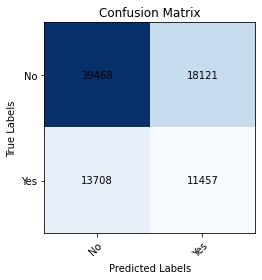

In [24]:
best_rf = random_search_rf.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Random Forest Test Results:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print("Classification Report:")
print('------------------------------------------------------')
print(classification_report(y_test, y_pred_rf))
print('------------------------------------------------------')
cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm, ['No', 'Yes'])


### SVM

In [ ]:
best_svm = random_search_svm.best_estimator_

# Predict on the test set
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)

print("SVM Test Results:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"ROC AUC: {roc_auc_svm:.4f}")
print("Classification Report:")
print('------------------------------------------------------')
print(classification_report(y_test, y_pred_svm))
print('------------------------------------------------------')
cm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm, ['No', 'Yes'])



### XGBoost

Logistic Regression Test Results:
Accuracy: 0.5561
ROC AUC: 0.5939
Classification Report:
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.54      0.63     57589
           1       0.36      0.60      0.45     25165

    accuracy                           0.56     82754
   macro avg       0.56      0.57      0.54     82754
weighted avg       0.63      0.56      0.57     82754

------------------------------------------------------


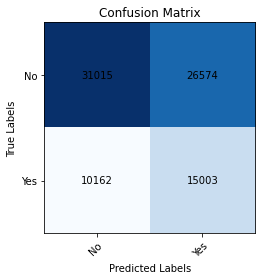

In [25]:
best_lr = random_search_xgb.best_estimator_

# Predict on the test set
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("Logistic Regression Test Results:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"ROC AUC: {roc_auc_lr:.4f}")
print("Classification Report:")
print('------------------------------------------------------')
print(classification_report(y_test, y_pred_lr))
print('------------------------------------------------------')
cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, ['No', 'Yes'])